# Experiment One

The first study, called `experiment-one`, looked at the effect of social influence on curiousity, using upvotes as proxy for social interest. Below we analyze the responses to test the hypothesis that the same questions, when given higher upvotes, receive higher scores from participants with regards to curiousity. And, further, whether this translates into participants being more likely to choose to view the answers to the questions with higher upvotes.

## Analysis

In [110]:
%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [146]:
# Analytical Tools
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

# General Utilities
import math
import json
import pprint
import itertools
import importlib

# Custom Utilities
import utilities.processing as processing
import utilities.plotting as plotting
import utilities.describe as describe

# Some settings
from IPython.display import Markdown, display
log = pprint.pprint
printmd = lambda text: display(Markdown(text))
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/hermish/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Reading Data and Defining Constants

In [112]:
FILE_NAMES = [
    'raw-data/questions-and-answers-clean.json',
    'raw-data/judgments.json',
    'raw-data/responses.json'
]

NUM_QUESTIONS, NUM_JUDGEMENTS = 10, 7
GROUP_SIZE = NUM_QUESTIONS // 2

ALL_LABELS = processing.get_all_labels(NUM_QUESTIONS)
LOW_LABELS, HIGH_LABELS = ALL_LABELS[:GROUP_SIZE], ALL_LABELS[GROUP_SIZE:]
JUDGMENT_LABELS = processing.get_judgment_labels(NUM_JUDGEMENTS)

LITERALS = []
for name in FILE_NAMES[:2]:
    with open(name) as file:
         LITERALS.append(json.load(file))
with open(FILE_NAMES[2]) as file:
    master_responses = [json.loads(line) for line in file if line]

### Reading Responses into Data
Creates a `DataFrame` based on the survey data.

In [113]:
col_labels = processing.get_col_labels(NUM_QUESTIONS,
                                       NUM_JUDGEMENTS)
data = {label: [] for label in col_labels}

In [114]:
processing.fill_experiment_three_data(data, master_responses)

In [115]:
data = pd.DataFrame(data)
data = data[data.consent == 1]
print(data.size, len(data))
data.head()

30401 301


,consent,high_q0_choice,high_q0_index,high_q0_j0,high_q0_j1,high_q0_j2,high_q0_j3,high_q0_j4,high_q0_j5,high_q0_j6,...,low_q4_choice,low_q4_index,low_q4_j0,low_q4_j1,low_q4_j2,low_q4_j3,low_q4_j4,low_q4_j5,low_q4_j6,low_q4_score
0,1,1,38,3,3,2,1,3,4,2,...,0,12,4,3,4,2,3,3,1,31
1,1,0,21,3,3,3,3,3,3,4,...,1,10,3,3,3,3,3,4,3,33
2,1,1,31,4,1,3,3,5,2,2,...,1,0,2,2,3,3,3,1,2,22
3,1,0,41,4,4,1,4,4,3,2,...,1,15,2,1,4,4,1,3,3,18
4,1,1,37,3,3,4,4,3,1,2,...,0,18,3,4,4,3,3,2,3,30


### Simple T-Tests
We first attempt to replicate the results of the first experiment by once again conducting a paired samples t-test.

In [122]:
# Update the table with intermediate values
low_means, low_err = [], []
high_means, high_err = [], []
sample_size = len(data)

for j_label in JUDGMENT_LABELS:
    low_headers = ['{}_{}'.format(q_label, j_label) for q_label in LOW_LABELS]
    high_headers = ['{}_{}'.format(q_label, j_label) for q_label in HIGH_LABELS]
    low_data = data[low_headers].mean(axis=1)
    high_data = data[high_headers].mean(axis=1)
    
    data['{}_low'.format(j_label)] = low_data
    data['{}_high'.format(j_label)] = high_data
    data['{}_diff'.format(j_label)] = high_data - low_data
    
    low_means.append(low_data.mean())
    low_err.append(low_data.std() / math.sqrt(sample_size))
    high_means.append(high_data.mean())
    high_err.append(high_data.std() / math.sqrt(sample_size))

Curiosity: t = -6.68, p = 1.22e-10 (1 greater)
Confidence: t = 0.112, p = 0.911 (0 greater)
Usefulness: t = -4.98, p = 1.08e-06 (1 greater)
Popularity: t = -23.1, p = 9.88e-68 (1 greater)
Writing: t = -5.56, p = 6.1e-08 (1 greater)
Surprise: t = -6.48, p = 3.9e-10 (1 greater)
Social Utility: t = -6.46, p = 4.28e-10 (1 greater)


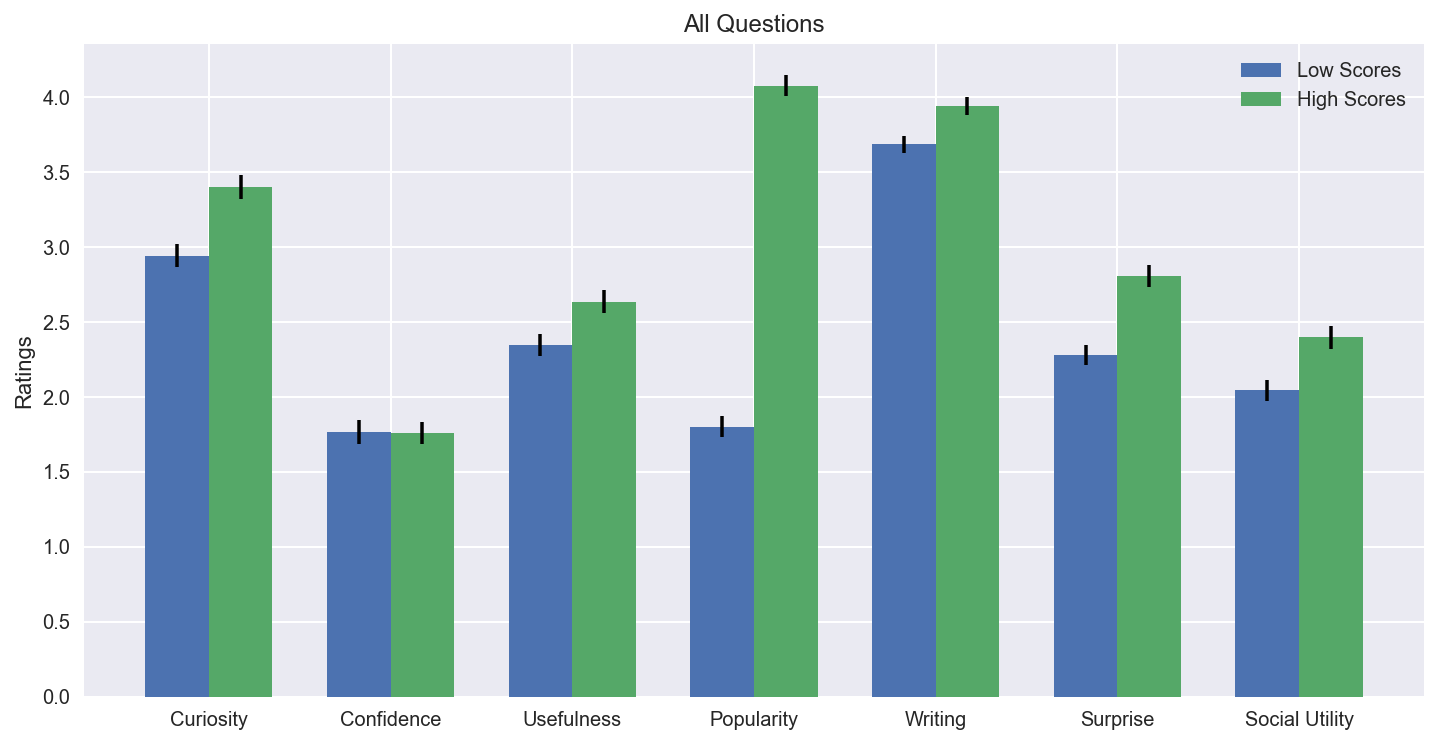

In [123]:
# Compute averages, run t-test and plot
PLOTTING_OPTIONS = {
    'y_label': 'Ratings',
    'ticks': ['Curiosity', 'Confidence', 'Usefulness',
              'Popularity', 'Writing', 'Surprise', 'Social Utility'],
    'legend': ['Low Scores', 'High Scores'],
    'title': 'All Questions',
    'size': (12, 6)
}

for index, j_label in enumerate(JUDGMENT_LABELS):
    low_data = data['{}_low'.format(j_label)]
    high_data = data['{}_high'.format(j_label)]
    print('{}: {}'.format(PLOTTING_OPTIONS['ticks'][index],
                          describe.paired_t_test(low_data, high_data)))

plotting.plot_double_bar(low_means, low_err, high_means,
                         high_err, **PLOTTING_OPTIONS)

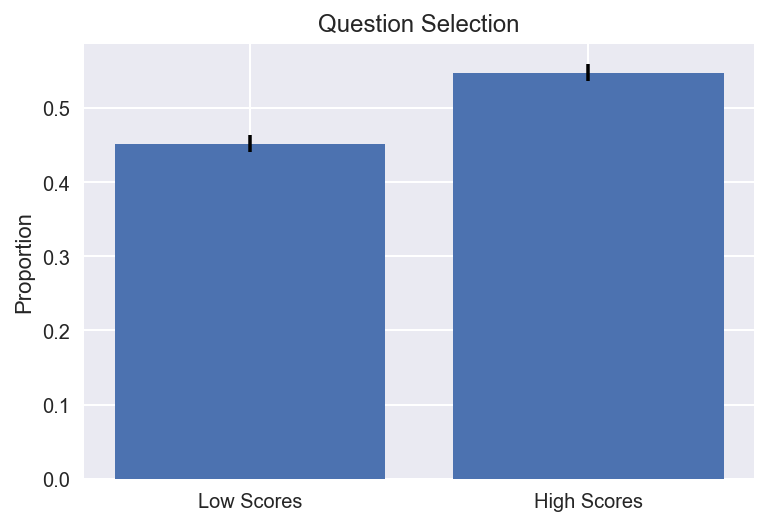

0.5479452054794521
t = 4.24, p = 3.06e-05 (greater)
Effect size: 0.09589041095890422


In [124]:
import importlib
importlib.reload(plotting)

PLOTTING_OPTIONS = {
    'y_label': 'Proportion',
    'ticks': ['Low Scores', 'High Scores'],
    'title': 'Question Selection',
    'save': 'choices.pdf'
}

low_choice_labels = ['{}_choice'.format(q_label) for q_label in LOW_LABELS]
high_choice_labels = ['{}_choice'.format(q_label) for q_label in HIGH_LABELS]
low_choice_means = data[low_choice_labels].mean(axis=1)
high_choice_means = data[high_choice_labels].mean(axis=1)
low_mean = low_choice_means.mean()
high_mean = high_choice_means.mean()

plotting.plot_single_bar(
    [low_mean, high_mean],
    [low_choice_means.std() / math.sqrt(sample_size),
    high_choice_means.std() / math.sqrt(sample_size)],
    **PLOTTING_OPTIONS)

print(high_choice_means.mean())
print(describe.one_sample_t_test(high_choice_means, 0.5))
print('Effect size: {}'.format(high_mean - low_mean))

### Examining Participants Without Variance

New we consider elimating participants with little to no variance to determine if this had any noticable effect on our results. For example, particpant number two in our study had a variance of 0.2, meaning nearly ever response he or she gave was 3; we remove all such particpants and test for significance in the same way.

In [125]:
all_judgment_headers = ['{}_{}'.format(q_label, j_label) for 
                        q_label, j_label in itertools.product(
                            ALL_LABELS, JUDGMENT_LABELS)]
data['total_var'] = data[all_judgment_headers].std(axis=1)

In [126]:
data = data[data.total_var > 0.75]
print('{} eliminated'.format(sample_size - len(data)))

PLOTTING_OPTIONS = {
    'ticks': ['Curiosity', 'Confidence', 'Usefulness',
              'Popularity', 'Writing', 'Surprise', 'Social Utility']}

printmd('**Original Survey**')
for index, j_label in enumerate(JUDGMENT_LABELS):
    low_data = data['{}_low'.format(j_label)]
    high_data = data['{}_high'.format(j_label)]
    print('{}: {}'.format(PLOTTING_OPTIONS['ticks'][index],
                          describe.paired_t_test(low_data, high_data)))
    
printmd('**Choice Analysis**')
high_choice_labels = ['{}_choice'.format(q_label) for q_label in HIGH_LABELS]
high_choice_means = data[high_choice_labels].mean(axis=1)
high_mean = high_choice_means.mean()
print(describe.one_sample_t_test(high_choice_means, 0.5))
print('Effect size: {}'.format(2 * high_mean - 1))

0 eliminated


**Original Survey**

Curiosity: t = -6.68, p = 1.22e-10 (1 greater)
Confidence: t = 0.112, p = 0.911 (0 greater)
Usefulness: t = -4.98, p = 1.08e-06 (1 greater)
Popularity: t = -23.1, p = 9.88e-68 (1 greater)
Writing: t = -5.56, p = 6.1e-08 (1 greater)
Surprise: t = -6.48, p = 3.9e-10 (1 greater)
Social Utility: t = -6.46, p = 4.28e-10 (1 greater)


**Choice Analysis**

t = 4.24, p = 3.06e-05 (greater)
Effect size: 0.09589041095890427


### Mediation Analysis

In [142]:
# Aggreate all questions and choice
flattened_data = {'group': [], 'curiosity': [], 'choice': []}
for index, row in data.iterrows():
    for q_label in ALL_LABELS:
        level = 1 if row['{}_score'.format(q_label)] > 240.9 else 0
        flattened_data['group'].append(level)
        flattened_data['curiosity'].append(row['{}_j0'.format(q_label)])
        flattened_data['choice'].append(row['{}_choice'.format(q_label)])

In [143]:
new_data = pd.DataFrame(flattened_data)

In [148]:
X = flattened_data['curiosity']
y = flattened_data['choice']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     446.3
Date:                Tue, 23 Jan 2018   Prob (F-statistic):           2.69e-92
Time:                        11:19:57   Log-Likelihood:                -1911.5
No. Observations:                2920   AIC:                             3827.
Df Residuals:                    2918   BIC:                             3839.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2063      0.016     12.612      0.000       0.174       0.238
x1             0.0926      0.004     21.125      0.000       0.084       0.101
==============================================================================
Omnibus:                        0.147   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.929   Jarque-Bera (JB):              251.475
Skew:                          -0.017   Prob(JB):                     2.47e-55
Kurtosis:                       1.563   Cond. No.                         7.45
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""